Source [link](https://towardsdatascience.com/getting-started-with-graph-analysis-in-python-with-pandas-and-networkx-5e2d2f82f18e)

# Complex fraud structure


> Working on connections between users can show a lot more information than you had simply by looking at raw data.

Specifically, features that would not be considered risky for a usual machine-learning based scoring model (phone number, email address, home address) can become features of risk in a graph based scoring model. 

> Example: three individuals with the same phone numbers, connected to other individuals with the same email addresses is unusual and potentially risky. The value of the phone number does not give any information in itself (therefore even the best deep learning model would not capture any value out of it), but the fact that individuals are connected through the same values of phone numbers, or email addresses can be synonym of risk.

In [1]:
import pandas as pd

df = pd.DataFrame({'ID':[1,2,3,4,5,6], 
                   'First Name':['Felix', 'Jean', 'James', 'Daphne', 'James', 'Peter'], 
                   'Family Name': ['Revert', 'Durand', 'Wright', 'Hull', 'Conrad', 'Donovan'],
                   'Phone number': ['+33 6 12 34 56 78', '+33 7 00 00 00 00', '+33 6 12 34 56 78', '+33 6 99 99 99 99', '+852 0123 4567', '+852 0123 4567'],
                   'Email': ['felix.revert@gmail.com', 'jean.durand@gmail.com', 'j.custom@gmail.com', pd.np.nan, 'j.custom@gmail.com', pd.np.nan]})

In [2]:
df

,ID,First Name,Family Name,Phone number,Email
0,1,Felix,Revert,+33 6 12 34 56 78,felix.revert@gmail.com
1,2,Jean,Durand,+33 7 00 00 00 00,jean.durand@gmail.com
2,3,James,Wright,+33 6 12 34 56 78,j.custom@gmail.com
3,4,Daphne,Hull,+33 6 99 99 99 99,NaN
4,5,James,Conrad,+852 0123 4567,j.custom@gmail.com
5,6,Peter,Donovan,+852 0123 4567,NaN


In [3]:
column_edge = 'Phone number'
column_ID = 'ID'

data_to_merge = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN
data_to_merge

,ID,Phone number
0,1,+33 6 12 34 56 78
1,2,+33 7 00 00 00 00
2,3,+33 6 12 34 56 78
3,4,+33 6 99 99 99 99
4,5,+852 0123 4567
5,6,+852 0123 4567


In [4]:
# To create connections between people who have the same number,
# join data with itself on the 'ID' column.
data_to_merge = data_to_merge.merge(
    data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
    on=column_edge
)
data_to_merge

,ID,Phone number,ID_2
0,1,+33 6 12 34 56 78,1
1,1,+33 6 12 34 56 78,3
2,3,+33 6 12 34 56 78,1
3,3,+33 6 12 34 56 78,3
4,2,+33 7 00 00 00 00,2
5,4,+33 6 99 99 99 99,4
6,5,+852 0123 4567,5
7,5,+852 0123 4567,6
8,6,+852 0123 4567,5
9,6,+852 0123 4567,6


In [5]:
# By joining the data with itself, people will have a connection with themselves.
# Remove self connections, to keep only connected people who are different.
d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]]
    
# To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
# we force the first ID to be "lower" then ID_2
d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)

In [6]:
d

,ID,ID_2,Phone number
1,1,3,+33 6 12 34 56 78
7,5,6,+852 0123 4567


In [7]:
import networkx as nx

G = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)

G.add_nodes_from(nodes_for_adding=df.ID.tolist())

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


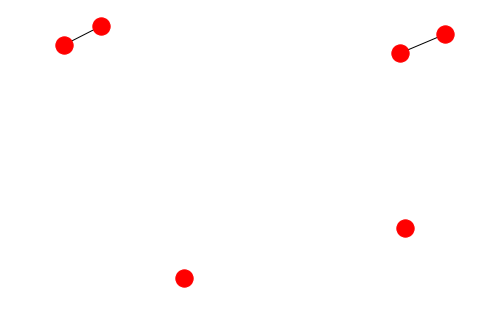

In [8]:
%matplotlib inline
nx.draw(G)

### Risky pattern detection
Two ways to proceed here:

 - go from individuals who you consider risky (or who you detected as fraudsters) and check their relationships to other individuals. To relate to Machine Learning, it would be a kind of “supervised” method. To go further, you can also start from a Machine Learning scoring (made with XGBoost for instance) and look for their close connections.
 - go from strange patterns (too many connections, dense network…). This would be the “unsupervised” method